# 1. 在多分类任务实验中分别手动实现和用torch.nn实现dropout
+  探究不同丢弃率对实验结果的影响（可用loss曲线进行展示）

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)

# 定义数据转换，标准化MNIST数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# 加载MNIST数据集
train_data = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

## 1. 手动实现Dropout

In [ ]:
class ManualDropoutModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ManualDropoutModel, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.manual_dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.manual_dropout(x)
        x = self.fc3(x)
        return x
    
    def manual_dropout(self, x):
        # 手动Dropout实现
        if self.training:
            mask = (torch.rand_like(x) > self.dropout_rate).float()
            return x * mask / (1 - self.dropout_rate)
        else:
            return x

## 2. 使用torch.nn.Dropout实现Dropout

In [ ]:
class NNWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NNWithDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_rate)  # 使用torch.nn.Dropout
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
# 训练函数
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

In [ ]:
# 测试函数
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return avg_test_loss, test_accuracy

In [ ]:
# 进行不同丢弃率的实验
dropout_rates = [0.2, 0.4, 0.5]
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 用于记录不同丢弃率的损失和准确度
losses_manual = []
accs_manual = []
losses_dropout = []
accs_dropout = []

In [ ]:
for rate in dropout_rates:
    # 1. 手动Dropout
    model_manual = ManualDropoutModel(dropout_rate=rate).to(device)
    optimizer = optim.Adam(model_manual.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    loss_curve_manual = []
    print(f"Training with Manual Dropout (rate={rate})...")
    for epoch in range(epochs):
        # Train
        avg_train_loss, train_accuracy = train(model_manual, train_loader, optimizer, criterion, device)
        
        # Test
        avg_test_loss, test_accuracy = test(model_manual, test_loader, criterion, device)

        # 打印每个epoch的结果
        print(f"epoch: {epoch+1:2d} | "
              f"train loss:{avg_train_loss:12.5f} | "
              f"test loss:{avg_test_loss:12.5f} | "
              f"train acc: {train_accuracy:4.2f} | "
              f"test acc: {test_accuracy:4.2f}")

        loss_curve_manual.append(avg_test_loss)
    
    losses_manual.append(loss_curve_manual)
    
    # 2. 使用torch.nn.Dropout
    model_dropout = NNWithDropout(dropout_rate=rate).to(device)
    optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)
    loss_curve_dropout = []
    print(f"Training with torch.nn.Dropout (rate={rate})...")
    for epoch in range(epochs):
        # Train
        avg_train_loss, train_accuracy = train(model_dropout, train_loader, optimizer, criterion, device)
        
        # Test
        avg_test_loss, test_accuracy = test(model_dropout, test_loader, criterion, device)

        # 打印每个epoch的结果
        print(f"epoch: {epoch+1:2d} | "
              f"train loss:{avg_train_loss:12.5f} | "
              f"test loss:{avg_test_loss:12.5f} | "
              f"train acc: {train_accuracy:4.2f} | "
              f"test acc: {test_accuracy:4.2f}")

        loss_curve_dropout.append(avg_test_loss)
    
    losses_dropout.append(loss_curve_dropout)

In [ ]:
# 可视化不同丢弃率下的损失曲线
plt.figure(figsize=(10, 6))

for i, rate in enumerate(dropout_rates):
    plt.plot(range(epochs), losses_manual[i], label=f'Manual Dropout {rate}')
    plt.plot(range(epochs), losses_dropout[i], label=f'Torch Dropout {rate}', linestyle='--')

plt.title("Loss Curves with Different Dropout Rates")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 完整代码

Training with Manual Dropout (rate=0.2)...
epoch:  1 | train loss:     0.48807 | test loss:     0.24684 | train acc: 84.93 | test acc: 92.58
epoch:  2 | train loss:     0.26367 | test loss:     0.16184 | train acc: 92.02 | test acc: 95.11
epoch:  3 | train loss:     0.21395 | test loss:     0.13335 | train acc: 93.54 | test acc: 95.92
epoch:  4 | train loss:     0.18915 | test loss:     0.12323 | train acc: 94.21 | test acc: 96.03
epoch:  5 | train loss:     0.17368 | test loss:     0.10888 | train acc: 94.73 | test acc: 96.39
epoch:  6 | train loss:     0.16153 | test loss:     0.11032 | train acc: 95.08 | test acc: 96.59
epoch:  7 | train loss:     0.15373 | test loss:     0.10033 | train acc: 95.26 | test acc: 96.83
epoch:  8 | train loss:     0.15069 | test loss:     0.10084 | train acc: 95.41 | test acc: 96.90
epoch:  9 | train loss:     0.14253 | test loss:     0.09618 | train acc: 95.63 | test acc: 97.21
epoch: 10 | train loss:     0.13316 | test loss:     0.10416 | train acc: 9

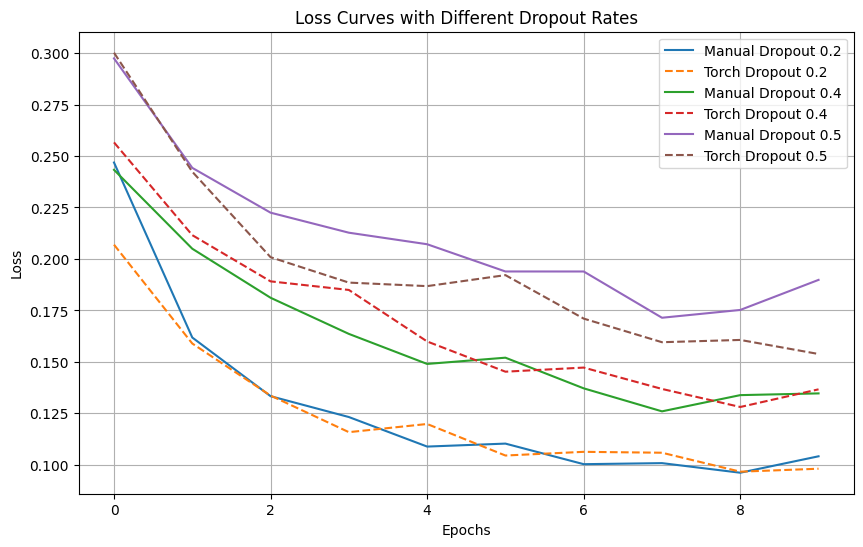

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)

# 定义数据转换，标准化MNIST数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载MNIST数据集
train_data = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

# 1. 手动实现Dropout
class ManualDropoutModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ManualDropoutModel, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.manual_dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.manual_dropout(x)
        x = self.fc3(x)
        return x
    
    def manual_dropout(self, x):
        # 手动Dropout实现
        if self.training:
            mask = (torch.rand_like(x) > self.dropout_rate).float()
            return x * mask / (1 - self.dropout_rate)
        else:
            return x

# 2. 使用torch.nn.Dropout实现Dropout
class NNWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NNWithDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout_rate)  # 使用torch.nn.Dropout
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 训练函数
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

# 测试函数
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    return avg_test_loss, test_accuracy

# 进行不同丢弃率的实验
dropout_rates = [0.2, 0.4, 0.5]
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 用于记录不同丢弃率的损失和准确度
losses_manual = []
accs_manual = []
losses_dropout = []
accs_dropout = []

for rate in dropout_rates:
    # 1. 手动Dropout
    model_manual = ManualDropoutModel(dropout_rate=rate).to(device)
    optimizer = optim.Adam(model_manual.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    loss_curve_manual = []
    print(f"Training with Manual Dropout (rate={rate})...")
    for epoch in range(epochs):
        # Train
        avg_train_loss, train_accuracy = train(model_manual, train_loader, optimizer, criterion, device)
        
        # Test
        avg_test_loss, test_accuracy = test(model_manual, test_loader, criterion, device)

        # 打印每个epoch的结果
        print(f"epoch: {epoch+1:2d} | "
              f"train loss:{avg_train_loss:12.5f} | "
              f"test loss:{avg_test_loss:12.5f} | "
              f"train acc: {train_accuracy:4.2f} | "
              f"test acc: {test_accuracy:4.2f}")

        loss_curve_manual.append(avg_test_loss)
    
    losses_manual.append(loss_curve_manual)
    
    # 2. 使用torch.nn.Dropout
    model_dropout = NNWithDropout(dropout_rate=rate).to(device)
    optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)
    loss_curve_dropout = []
    print(f"Training with torch.nn.Dropout (rate={rate})...")
    for epoch in range(epochs):
        # Train
        avg_train_loss, train_accuracy = train(model_dropout, train_loader, optimizer, criterion, device)
        
        # Test
        avg_test_loss, test_accuracy = test(model_dropout, test_loader, criterion, device)

        # 打印每个epoch的结果
        print(f"epoch: {epoch+1:2d} | "
              f"train loss:{avg_train_loss:12.5f} | "
              f"test loss:{avg_test_loss:12.5f} | "
              f"train acc: {train_accuracy:4.2f} | "
              f"test acc: {test_accuracy:4.2f}")

        loss_curve_dropout.append(avg_test_loss)
    
    losses_dropout.append(loss_curve_dropout)

# 可视化不同丢弃率下的损失曲线
plt.figure(figsize=(10, 6))

for i, rate in enumerate(dropout_rates):
    plt.plot(range(epochs), losses_manual[i], label=f'Manual Dropout {rate}')
    plt.plot(range(epochs), losses_dropout[i], label=f'Torch Dropout {rate}', linestyle='--')

plt.title("Loss Curves with Different Dropout Rates")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()